# Simple Example

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics

from raimitigations.dataprocessing import Rebalance, EncoderOrdinal, EncoderOHE, BasicImputer, SeqFeatSelection, CatBoostSelection, Synthesizer, Rebalance

In [2]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(estimator, y, y_pred):
	cm = metrics.confusion_matrix(y, y_pred, labels=estimator.classes_)
	print(cm)
	cm = metrics.confusion_matrix(y, y_pred, labels=estimator.classes_, normalize='true')
	disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
	disp.plot(cmap=plt.cm.Blues)
	disp.ax_.set_title('Confusion Matrix')
	plt.show()

In [3]:
data_dir = '../../../datasets/hr_promotion'
dataset =  pd.read_csv(data_dir + '/train.csv')
dataset.drop(columns=['employee_id'], inplace=True)
dataset

department     region         education gender  \
0      Sales & Marketing   region_7  Master's & above      f   
1             Operations  region_22        Bachelor's      m   
2      Sales & Marketing  region_19        Bachelor's      m   
3      Sales & Marketing  region_23        Bachelor's      m   
4             Technology  region_26        Bachelor's      m   
...                  ...        ...               ...    ...   
54803         Technology  region_14        Bachelor's      m   
54804         Operations  region_27  Master's & above      f   
54805          Analytics   region_1        Bachelor's      m   
54806  Sales & Marketing   region_9               NaN      m   
54807                 HR  region_22        Bachelor's      m   

      recruitment_channel  no_of_trainings  age  previous_year_rating  \
0                sourcing                1   35                   5.0   
1                   other                1   30                   5.0   
2                sourcing                1   34                   3.0   
3                   other                2   39                   1.0   
4                   other                1   45                   3.0   
...                   ...              ...  ...                   ...   
54803            sourcing                1   48                   3.0   
54804               other                1   37                   2.0   
54805               other                1   27                   5.0   
54806            sourcing                1   29                   1.0   
54807               other                1   27                   1.0   

       length_of_service  awards_won?  avg_training_score  is_promoted  
0                      8            0                  49            0  
1                      4            0                  60            0  
2                      7            0                  50            0  
3                     10            0                  50            0  
4                      2            0                  73            0  
...                  ...          ...                 ...          ...  
54803                 17            0                  78            0  
54804                  6            0                  56            0  
54805                  3            0                  79            0  
54806                  2            0                  45            0  
54807                  5            0                  49            0  

[54808 rows x 12 columns]

## 1 - Base Model

Define a function that splits the data into train and test sets. We then use the function to split the data.

In [4]:
label_col = 'is_promoted'

def split_data(df, label, test_size=0.2, full_df=False):
	X = df.drop(columns=[label])
	y = df[label]
	train_x, test_x, train_y, test_y = train_test_split(
											X, y, 
											test_size=test_size,
											stratify=y
										)
	if full_df:
		train_df = train_x
		train_df[label] = train_y
		test_df = test_x
		test_df[label] = test_y
		return train_df, test_df
		
	return train_x, test_x, train_y, test_y

train_x, test_x, train_y, test_y = split_data(dataset, label_col)
org_train_x = train_x
org_train_y = train_y
org_test_x = test_x
org_test_y = test_y
train_x

department     region         education gender  \
31648                 HR   region_2        Bachelor's      f   
13743         Operations  region_29  Master's & above      m   
34156        Procurement   region_3        Bachelor's      m   
37856         Operations   region_7        Bachelor's      m   
41155         Technology  region_13        Bachelor's      f   
...                  ...        ...               ...    ...   
48452         Technology   region_2   Below Secondary      m   
3967           Analytics   region_4        Bachelor's      m   
44096  Sales & Marketing  region_18        Bachelor's      m   
8672                  HR   region_2  Master's & above      m   
26442            Finance   region_2  Master's & above      m   

      recruitment_channel  no_of_trainings  age  previous_year_rating  \
31648            sourcing                1   50                   5.0   
13743               other                2   35                   4.0   
34156            sourcing                1   29                   4.0   
37856               other                1   34                   3.0   
41155            sourcing                1   28                   NaN   
...                   ...              ...  ...                   ...   
48452            sourcing                1   20                   3.0   
3967                other                1   31                   3.0   
44096               other                1   30                   2.0   
8672             sourcing                1   43                   4.0   
26442            sourcing                1   34                   3.0   

       length_of_service  awards_won?  avg_training_score  
31648                  7            0                  46  
13743                  2            0                  57  
34156                  4            0                  68  
37856                  8            0                  59  
41155                  1            0                  78  
...                  ...          ...                 ...  
48452                  2            0                  81  
3967                   3            0                  86  
44096                  6            0                  49  
8672                   5            0                  51  
26442                  8            0                  57  

[43846 rows x 11 columns]

Many models can't handle categorical data and missing values, so we cannot train the model just yet. First we need to encode all categorical data and remove missing values.

In [5]:
imputer = BasicImputer(specific_col={'previous_year_rating': {	'missing_values':np.nan, 
																'strategy':'constant', 
																'fill_value':-100 } } )
encoder = EncoderOrdinal(categories={'education': ["Below Secondary", "Bachelor's", "Master's & above"]})

imputer.fit(train_x)
train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

train_x

No columns specified for imputation. These columns have been automatically identified:
['education', 'previous_year_rating']


department     region         education gender  \
31648                 HR   region_2        Bachelor's      f   
13743         Operations  region_29  Master's & above      m   
34156        Procurement   region_3        Bachelor's      m   
37856         Operations   region_7        Bachelor's      m   
41155         Technology  region_13        Bachelor's      f   
...                  ...        ...               ...    ...   
48452         Technology   region_2   Below Secondary      m   
3967           Analytics   region_4        Bachelor's      m   
44096  Sales & Marketing  region_18        Bachelor's      m   
8672                  HR   region_2  Master's & above      m   
26442            Finance   region_2  Master's & above      m   

      recruitment_channel  no_of_trainings   age  previous_year_rating  \
31648            sourcing              1.0  50.0                   5.0   
13743               other              2.0  35.0                   4.0   
34156            sourcing              1.0  29.0                   4.0   
37856               other              1.0  34.0                   3.0   
41155            sourcing              1.0  28.0                -100.0   
...                   ...              ...   ...                   ...   
48452            sourcing              1.0  20.0                   3.0   
3967                other              1.0  31.0                   3.0   
44096               other              1.0  30.0                   2.0   
8672             sourcing              1.0  43.0                   4.0   
26442            sourcing              1.0  34.0                   3.0   

       length_of_service  awards_won?  avg_training_score  
31648                7.0          0.0                46.0  
13743                2.0          0.0                57.0  
34156                4.0          0.0                68.0  
37856                8.0          0.0                59.0  
41155                1.0          0.0                78.0  
...                  ...          ...                 ...  
48452                2.0          0.0                81.0  
3967                 3.0          0.0                86.0  
44096                6.0          0.0                49.0  
8672                 5.0          0.0                51.0  
26442                8.0          0.0                57.0  

[43846 rows x 11 columns]

In [6]:
encoder.fit(train_x)
train_x = encoder.transform(train_x)
test_x = encoder.transform(test_x)
train_x

No columns specified for encoding. These columns have been automatically identfied as the following:
['department', 'region', 'education', 'gender', 'recruitment_channel']


department  region  education  gender  recruitment_channel  \
31648           2      11          1       0                    2   
13743           4      21          2       1                    0   
34156           5      22          1       1                    2   
37856           4      31          1       1                    0   
41155           8       4          1       0                    2   
...           ...     ...        ...     ...                  ...   
48452           8      11          0       1                    2   
3967            0      28          1       1                    0   
44096           7       9          1       1                    0   
8672            2      11          2       1                    2   
26442           1      11          2       1                    2   

       no_of_trainings   age  previous_year_rating  length_of_service  \
31648              1.0  50.0                   5.0                7.0   
13743              2.0  35.0                   4.0                2.0   
34156              1.0  29.0                   4.0                4.0   
37856              1.0  34.0                   3.0                8.0   
41155              1.0  28.0                -100.0                1.0   
...                ...   ...                   ...                ...   
48452              1.0  20.0                   3.0                2.0   
3967               1.0  31.0                   3.0                3.0   
44096              1.0  30.0                   2.0                6.0   
8672               1.0  43.0                   4.0                5.0   
26442              1.0  34.0                   3.0                8.0   

       awards_won?  avg_training_score  
31648          0.0                46.0  
13743          0.0                57.0  
34156          0.0                68.0  
37856          0.0                59.0  
41155          0.0                78.0  
...            ...                 ...  
48452          0.0                81.0  
3967           0.0                86.0  
44096          0.0                49.0  
8672           0.0                51.0  
26442          0.0                57.0  

[43846 rows x 11 columns]

 Now we create the model and train it using the training set. In the sequence, test its performance over the test set. 

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10028
           1       0.29      0.30      0.29       934

    accuracy                           0.88     10962
   macro avg       0.61      0.62      0.61     10962
weighted avg       0.88      0.88      0.88     10962

[[9321  707]
 [ 651  283]]


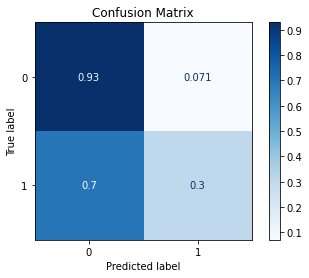

In [7]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def train_model_plot_results(x, y, x_test, y_test):
	model = DecisionTreeClassifier(max_features="sqrt")
	model.fit(x, y)
	pred = model.predict(x_test)
	print(metrics.classification_report(y_test, pred))
	plot_confusion_matrix(model, y_test, pred)
	return model

model = train_model_plot_results(train_x, train_y, test_x, test_y)

## 2 - Feature Selection

In [8]:
from sklearn.neighbors import KNeighborsClassifier

#estimator = KNeighborsClassifier(n_neighbors=4)
#feat_sel = SeqFeatSelection(estimator=estimator, scoring='f1', n_jobs=4)
feat_sel = SeqFeatSelection(scoring='f1', n_jobs=4)
feat_sel.fit(X=train_x, y=train_y)
feat_sel.get_selected_features()

No columns specified for imputation. These columns have been automatically identified:
[]
No columns specified for encoding. These columns have been automatically identfied as the following:
[]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:    1.3s finished

[2022-06-28 16:06:27] Features: 1/11 -- score: 0.19682103130149586[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished

[2022-06-28 16:06:27] Features: 2/11 -- score: 0.5093172576119507[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.2s finished

[2022-06-28 16:06:27] Features: 3/11 -- score: 0.5095222759433246[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    0.3s finished

[2022-06-28 16:06:28] Features: 4/11 -- score: 0.50557881553

['department', 'awards_won?', 'avg_training_score']

In [9]:
train_x = feat_sel.transform(train_x)
test_x = feat_sel.transform(test_x)
train_x

department  awards_won?  avg_training_score
31648         2.0          0.0                46.0
13743         4.0          0.0                57.0
34156         5.0          0.0                68.0
37856         4.0          0.0                59.0
41155         8.0          0.0                78.0
...           ...          ...                 ...
48452         8.0          0.0                81.0
3967          0.0          0.0                86.0
44096         7.0          0.0                49.0
8672          2.0          0.0                51.0
26442         1.0          0.0                57.0

[43846 rows x 3 columns]

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10028
           1       0.93      0.31      0.47       934

    accuracy                           0.94     10962
   macro avg       0.93      0.65      0.72     10962
weighted avg       0.94      0.94      0.92     10962

[[10006    22]
 [  644   290]]


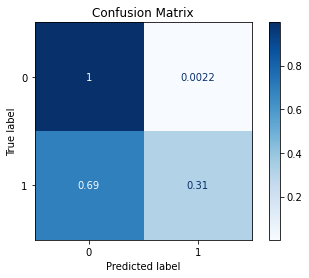

In [10]:
model = train_model_plot_results(train_x, train_y, test_x, test_y)

## 3 - Generating Synthetic Data + Feature Selection

In [11]:
dataset[label_col].value_counts(normalize=True)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

In [12]:
train_df = org_train_x.copy()
train_df[label_col] = org_train_y
test_x = org_test_x
test_y = org_test_y

train_df[label_col].value_counts(normalize=True)

0    0.914838
1    0.085162
Name: is_promoted, dtype: float64

In [13]:
synth = Synthesizer(
				df=train_df,
				label_col=label_col,
				model='ctgan',
				epochs=150,
				load_existing=False
			)
synth.fit()
balance_train = synth.transform(df=train_df, strategy=0.3)
balance_train[label_col].value_counts(normalize=True)

/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:143: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  cluster.KMeans(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/

0    0.76924
1    0.23076
Name: is_promoted, dtype: float64

No columns specified for imputation. These columns have been automatically identified:
['education', 'previous_year_rating']
No columns specified for encoding. These columns have been automatically identfied as the following:
['department', 'region', 'education', 'gender', 'recruitment_channel']
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     10028
           1       0.22      0.43      0.29       934

    accuracy                           0.83     10962
   macro avg       0.58      0.64      0.60     10962
weighted avg       0.88      0.83      0.85     10962

[[8646 1382]
 [ 536  398]]


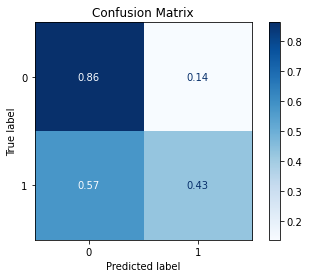

In [14]:
train_x = balance_train.drop(columns=[label_col])
train_y = balance_train[label_col]

imputer = BasicImputer(specific_col={'previous_year_rating': {	'missing_values':np.nan, 
																'strategy':'constant', 
																'fill_value':-100 } } )
encoder = EncoderOrdinal(categories={'education': ["Below Secondary", "Bachelor's", "Master's & above"]})

imputer.fit(train_x)
train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)

encoder.fit(train_x)
train_x = encoder.transform(train_x)
test_x = encoder.transform(test_x)

model = train_model_plot_results(train_x, train_y, test_x, test_y)

In [15]:
feat_sel = SeqFeatSelection(scoring='f1', n_jobs=4)
feat_sel.fit(X=train_x, y=train_y)
print(f"SELECTED FEATURES: {feat_sel.get_selected_features()}")
train_x_feat = feat_sel.transform(train_x)
test_x_feat = feat_sel.transform(test_x)
model = train_model_plot_results(train_x_feat, train_y, test_x_feat, test_y)

No columns specified for imputation. These columns have been automatically identified:
[]
No columns specified for encoding. These columns have been automatically identfied as the following:
[]


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:    1.5s finished

[2022-06-28 16:19:33] Features: 1/11 -- score: 0.38504722246930007[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished

[2022-06-28 16:19:33] Features: 2/11 -- score: 0.4378868097661957[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:    0.2s finished

[2022-06-28 16:19:34] Features: 3/11 -- score: 0.5817114928759861[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    0.2s finished

[2022-06-28 16:19:34] Features: 4/11 -- score: 0.58701267784

SELECTED FEATURES: ['department', 'previous_year_rating', 'awards_won?', 'avg_training_score']
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10028
           1       0.62      0.38      0.47       934

    accuracy                           0.93     10962
   macro avg       0.78      0.68      0.72     10962
weighted avg       0.92      0.93      0.92     10962

[[9804  224]
 [ 575  359]]


## 4 - Feature Selection + Synthetic Data

In [16]:
train_x = org_train_x
train_y = org_train_y
test_x = org_test_x
test_y = org_test_y

imputer = BasicImputer(specific_col={'previous_year_rating': {	'missing_values':np.nan, 
																'strategy':'constant', 
																'fill_value':-100 } } )
encoder = EncoderOHE()

feat_sel = SeqFeatSelection(scoring='f1', transform_pipe=[imputer, encoder], n_jobs=4, verbose=False)
feat_sel.fit(X=train_x, y=train_y)
print(f"SELECTED FEATURES: {feat_sel.get_selected_features()}")

train_x = feat_sel.transform(train_x)
test_x = feat_sel.transform(test_x)

model = train_model_plot_results(train_x, train_y, test_x, test_y)

No columns specified for imputation. These columns have been automatically identified:
['education', 'previous_year_rating']
No columns specified for encoding. These columns have been automatically identfied as the following:
['department', 'region', 'education', 'gender', 'recruitment_channel']
SELECTED FEATURES: ['awards_won?', 'avg_training_score', 'department_Finance', 'department_HR', 'department_Legal', 'department_Operations', 'department_Procurement', 'department_R&D', 'department_Sales & Marketing', 'department_Technology', 'region_region_10', 'region_region_15', 'region_region_18', 'region_region_19', 'region_region_21', 'region_region_29', 'region_region_9']
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10028
           1       0.91      0.30      0.45       934

    accuracy                           0.94     10962
   macro avg       0.92      0.65      0.71     10962
weighted avg       0.94      0.94      0.92     10

In [17]:
train_df = train_x
train_df[label_col] = train_y
test_df = test_x
test_df[label_col] = test_y

synth = Synthesizer(
				df=train_df,
				label_col=label_col,
				model='ctgan',
				epochs=130,
				load_existing=False
			)
synth.fit()
balance_train = synth.transform(df=train_df, strategy=0.3)
balance_train[label_col].value_counts(normalize=True)

/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/mmendonca/anaconda3/envs/rai/lib/python3.9/site-packages/ctgan/data_transformer.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].to_numpy().flatten()


0    0.76924
1    0.23076
Name: is_promoted, dtype: float64

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10028
           1       0.81      0.33      0.47       934

    accuracy                           0.94     10962
   macro avg       0.87      0.66      0.72     10962
weighted avg       0.93      0.94      0.92     10962

[[9955   73]
 [ 628  306]]


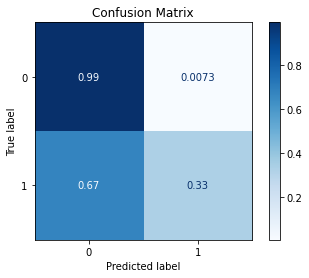

In [18]:
train_x = balance_train.drop(columns=[label_col])
train_y = balance_train[label_col]
test_x = test_df.drop(columns=[label_col])
test_y = test_df[label_col]

model = train_model_plot_results(train_x, train_y, test_x, test_y)